# MiDas

In [1]:
#pip install timm
import cv2
import torch
import urllib.request
import numpy as np

import matplotlib.pyplot as plt

In [2]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /mnt/nfs/kimura/.cache/torch/hub/intel-isl_MiDaS_master


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /mnt/nfs/kimura/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
filename = "I.jpg"
print(filename)

I.jpg


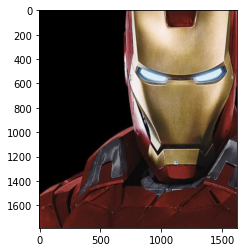

In [6]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)
plt.imshow(img)

In [7]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

(1786, 1622)

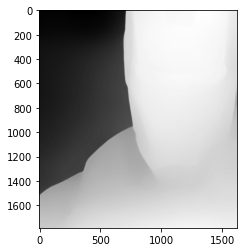

In [8]:
out = (output/output.max() * 255//1)
plt.imshow(out, cmap="gray")
# plt.show()
cv2.imwrite("./out.png", out)
output.shape

## ここまでがMiDasによる深度推定

In [9]:
def posterization(depth,n):
    th_bin, depth_bin = cv2. threshold(depth,0,255,cv2. THRESH_OTSU)
    ran = th_bin/ n
    out = np.zeros_like(depth)
    for i in range(n- 1):
        out = np.where( (i* ran<= depth)&(depth< (i+ 1)* ran), n- i, out )
    return out

In [10]:
def main(img_rgb, img_depth, resize_w, block_h):
    Height, Width = img_rgb. shape[:2]
    ratio = resize_w/ Width
    resize_rgb = cv2.resize(img_rgb, None , fx= ratio, fy= ratio, interpolation= cv2.INTER_NEAREST)
    resize_depth = cv2.resize(img_depth, None , fx= ratio, fy= ratio, interpolation= cv2.INTER_NEAREST)
    depth_pos = posterization(resize_depth, block_h)
    plt. figure(figsize= (20,15))
    plt. subplot(221)
    plt. imshow(img_rgb)
    plt. subplot(222)
    plt. imshow(img_depth, cmap= "gray")
    plt. subplot(223)
    plt. imshow(resize_rgb)
    plt. subplot(224)
    plt. imshow(depth_pos,cmap="gray")
    plt. show()
    
    return resize_rgb

In [11]:
img_depth = cv2.imread("out.png",0) 
img_depth = 255-img_depth

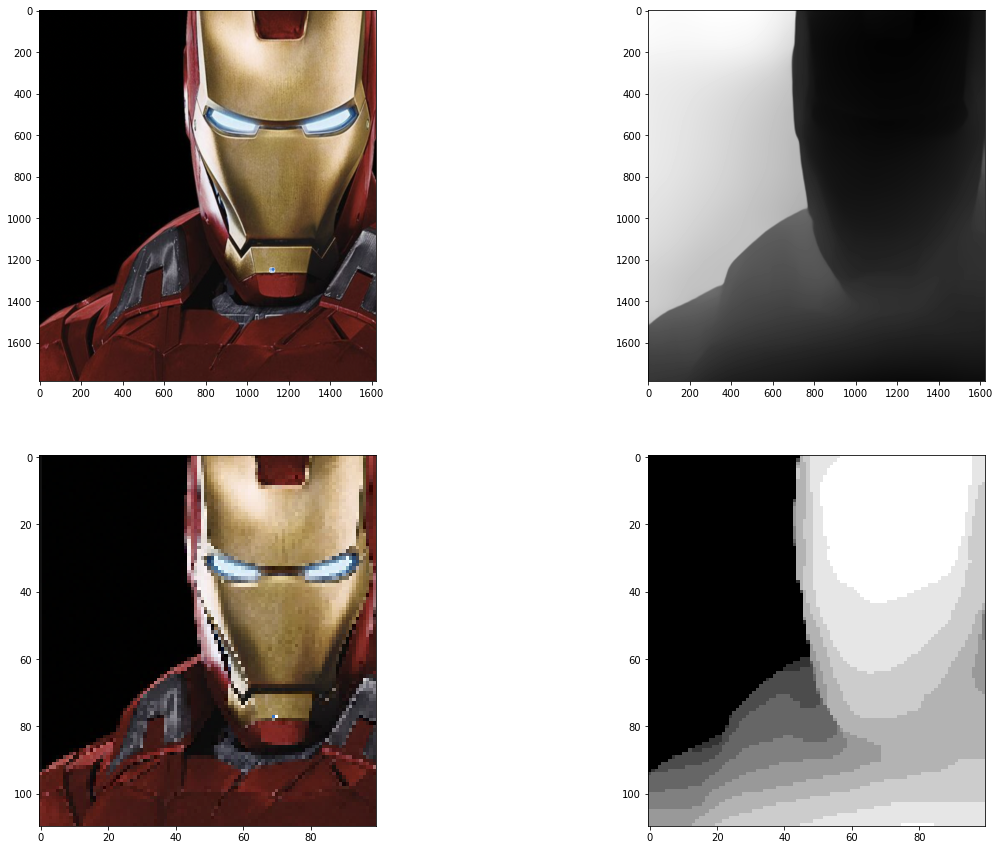

In [12]:
resize_rgb = main(img,img_depth,100,10)

In [13]:
#色を取得
import pandas as pd

df = pd.read_csv('./myfile.csv',header = 0)

rego_color = []
for i in range(len(df)):
    le = []
    le = [int(df["1"][i]),int(df["2"][i]),int(df["3"][i])]
    rego_color.append(le)

In [14]:
#レゴブロックの色全て
#rego_color = [[0,0,0],[201,26,9],[255,240,58],[255,255,255],[254,138,24],[198,204,218],[187,165,61],[246,215,179]]

test = resize_rgb

L = []
for n in test:
    diff_all = np.empty(len(test[0]))
    for m in rego_color:
        diff = abs(n - m) 
        diff_sum = np.sum(diff,axis=1)
        diff_all = np.vstack((diff_all,diff_sum))
    diff_all = np.delete(diff_all, 0, 0)
    min_diff = np.argmin(diff_all, axis=0)
    
    l = []
    for i in min_diff:
        l.append(rego_color[i])
    L.append(l)
        
arr_L = np.array(L)

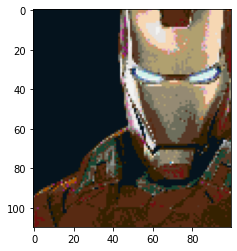

In [15]:
plt.imshow(arr_L)